---
# Examples of 2-D classifications using linear and quadratic discriminant analysis.
---

In this script, we show the differences in classification performances between the linear 
discriminant analysis (LDA) and the quadratic discriminant analysis (QDA) methods.

Both methods are applied to an "experimental" dataset generated from a mixture 
of gaussian probability distribution functions (PDF). Each one is weighted with its 
<i>a priori</i> class probability $P(C_{i})$:

<blockquote>  $P(\bf{x}) = \sum_{i=0}^{N}P(\bf{x}|C_{i}) P(C_{i})$ </blockquote>


The discriminant methods are used to locate the influence zone of each class i over a 
spatial grid. This corresponds to regions where 

<blockquote> $P(\bf{x}|C_{i}) P(C_{i}) > P(\bf{x}|C_{j \ne i}) P(C_{j \ne i})$ </blockquote>

or 

<blockquote> $h_{i}(\bf{x}) > h_{j \ne i}(\bf{x})$ </blockquote>

with the discriminant function $h_{i}(\bf{x})$ defined as

<blockquote>  $h_{i}(\bf{x}) = \ln P(\bf{x}|C_{i}) P(C_{i})$ </blockquote>
<br><br>
 

## Quadratic Discriminant Analysis 
Using the matrix form of the 2-D gaussian PDF, we obtain:

<blockquote>  $h_{i}(\bf{x}) =\frac{1}{2}\ln |\Sigma_{i}| -\frac{1}{2}(\bf{x}-\bf{\mu_{i}})^\top \Sigma_{i}^{-1} (\bf{x}-\bf{\mu_{i}}) + \ln P(C_{i})$  </blockquote>

with 

<blockquote>  The observation:   $\bf{x}=[x_{1} x_{2}]^\top$ </blockquote> 

<blockquote>  The origin:   $\bf{\mu_{i}} = [\mu_{1} \mu_{2}]^\top$  </blockquote> 

<blockquote>  The covariance matrix: $\Sigma_{i} = \begin{pmatrix} \sigma_{x_{1}}^2 & \sigma_{x_{1,2}} \\ \sigma_{x_{1,2}} & \sigma_{x_{2}}^2 \end{pmatrix}$ </blockquote>
<br><br>

## Linear Discriminant Analysis 
The size of the experimental dataset has a large effect on the precision of the classification results. 
If we assume the covariance matrices to be identical (<i>homoscedasticity</i>), we have 
 $\Sigma _{i}=\Sigma$. The shared covariance matrix $\Sigma$ is computed as a weighted mixture of the individual ones:

<blockquote>  $\Sigma = \sum_{i=0}^{N} P(C_{i}) \Sigma_{i}$ </blockquote>

The new discriminant equations are $\bf{linear}$ and can be simplified to:
    
<blockquote>  $h_{i}(\bf{x}) = \bf{\mu_{i}}^\top \Sigma^{-1} \bf{x} - \frac{1}{2}\bf{\mu_{i}}^\top \Sigma^{-1} \bf{\mu_{i}} + \ln P(C_{i})$  </blockquote>


This is a useful approximation to make when the number of data points is small or the dimensionality of the data is high.
<br><br>

This script was designed to handle gaussian mixtures with $\bf{TWO}$ or $\bf{THREE}$ components only. It is easy
to modify it to handle more complex distributions.
<br><br>

In [1]:
print(__doc__)

# Authors: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: XXX

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib import cm
from matplotlib.ticker import NullFormatter
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from scipy.stats import multivariate_normal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from skimage.transform import resize

import math

import seaborn as sns; sns.set()

cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.5, 0.5)],
     'green': [(0, 0.5, 0.5), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

Automatically created module for IPython interactive environment


# Part I: Detailed example with a two-component gaussian mixture 
Parameters of the two gaussians PDF:

In [2]:
# For replicability
np.random.seed(42)
        
# Centers of the PDF    
Mu = np.zeros((2,2))
Mu[0,:] = [-1., -1.]
Mu[1,:] = [1., 0.]

# Standard deviations along the principal axes (sigma_PCA_1 >= sigma_PCA_2)
sigma = np.zeros((2,2))
sigma[0,:] = [.8, .8]
sigma[1,:] = [1.5, .7]

# Rotation angles from the first principal axis
theta = np.array([0., -30]) 

npts = 200

# A priori class probabilities
prob_C = np.array([0.5, 0.5]) # PDF 1 and PDF 2



Compute the covariance matrix $\Sigma$ for each gaussian PDF. 
The $\Sigma$ matrix is defined as:

<blockquote>  $\Sigma = \begin{pmatrix} \sigma_{x_{1}}^2 & \sigma_{x_{1,2}} \\ \sigma_{x_{1,2}} & \sigma_{x_{2}}^2 \end{pmatrix}$ </blockquote>

Instead of using trials and errors to guess the values of $\sigma_{x_{1}}$, $\sigma_{x_{2}}$ and $\sigma_{x_{1,2}}$, we use instead the following method. 
We select values of $\sigma_{PCA_{1}}$, $\sigma_{PCA_{2}}$ for an ellipsoid aligned with the x and y axis and an 
angle $\theta$ to rotate the axes. The following code generates the $\Sigma$ matrices.

In [3]:
n_PDF = prob_C.shape[0]
Sigma = np.zeros((2, 2, n_PDF))
for n in range(n_PDF):
    cov = np.zeros((2, 2))

    # Rotation matrix
    angle = np.radians(theta[n])
    c, s = np.cos(angle), np.sin(angle)
    R = np.array([[c, -s], [s, c]])

    # Covariance matrix for a PDF with its principal axes oriented along the x and y directions
    C = np.array([[sigma[n,0]**2, 0.],[0., sigma[n,1]**2]])

    # Covariance matrix after rotation
    Sigma[:,:,n] = R.dot(C.dot(R.T))
    

Generate a spatial grid where the PDF will be evaluated locally.

In [4]:
nx, ny = 300, 300
x_min, x_max = -4., 4.
y_min, y_max = -3., 3.

xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
pos = np.dstack((xx, yy)) 

Compute the global PDF as a sum of weighted PDF

In [5]:
pdf = 0
for i in range(n_PDF):
    model = multivariate_normal(Mu[i,:], Sigma[:,:,i]) 
    pdf +=prob_C[i]*model.pdf(pos)


Generate a dataset of "experimental data" based on the two PDF. Estimate the PDF parameters from the dataset. 
The more data points we have, the better the parameter estimations and the more precise the classification results.

In [6]:
# Number of data points allocated to each PDF 
n = (npts*prob_C).astype(int)

Mu_hat = np.zeros((n_PDF,2))
Sigma_hat = np.zeros((2,2,n_PDF))

# Generate a dataset from the PDF component #0
X = np.random.multivariate_normal(Mu[0,:], Sigma[:,:,0], n[0])
y = np.zeros(n[0])

# Evaluate the gaussian PDF parameters from the dataset        
Mu_hat[0,:] = np.mean(X,axis=0)
Sigma_hat[:,:,0] = np.cov(X.T)         

for i in range(1,n_PDF):
    # Generate a dataset from the PDF component #i
    Xi = np.random.multivariate_normal(Mu[i,:], Sigma[:,:,i], n[i])
    yi = i*np.ones(n[i])

    # Store the dataset
    X = np.r_[X, Xi]        
    y = np.hstack((y, yi))

    # Evaluate the gaussian PDF parameters from the dataset   
    Mu_hat[i,:] = np.mean(Xi,axis=0)
    Sigma_hat[:,:,i] = np.cov(Xi.T)                      

pC_hat = prob_C

## Show the global PDF with the influence zone of each class.
Define a function that shows the influence zone of each class with the misclassified data points.

In [7]:
def plot_dataset(X,y, discriminant, xx, yy, ax):

    # Predict class on dataset
    y_pred = discriminant.fit(X, y).predict(X) 
    
    # True Positive
    tp = (y == y_pred)  
        
    # False Positive
    fp = (y != y_pred)  
        
    # Predict classes on the spatial grid     
    Xgrid = np.c_[xx.ravel(), yy.ravel()]
    C = discriminant.predict(Xgrid)  
    C = C.reshape(xx.shape)

    # Identify true and false positives for each class
    indx = np.where(tp)
    X_tp = np.squeeze( X[indx,:] )
    y_tp = y[indx]
    
    indx = np.where(fp)
    X_fp = np.squeeze( X[indx,:] )
    y_fp = y[indx]
    
     
    # Display classified data points (well classified '.', wrongly classified 'x')
    cmap1 = colors.ListedColormap(['red', 'blue', 'black'])
    cmap2 = colors.ListedColormap(['#990000', '#000099', '#000000'])
    ax.scatter(X_tp[:, 0], X_tp[:, 1], marker='.', cmap=cmap1, c=y_tp)
    ax.scatter(X_fp[:, 0], X_fp[:, 1], marker='x', s=20, cmap=cmap2, c=y_fp)

    
    # Display influence zone of each class
    n_PDF = y.max() + 1
    if (n_PDF==2):
        ax.pcolormesh(xx, yy, C, cmap='red_blue_classes', norm=colors.Normalize(0., 1.), zorder=0) 

        # Display the influence zone of each class
        ax.contour(xx, yy, C, [0.5], linewidths=2., colors='white') 
    else:
        ax.pcolormesh(xx, yy, C, cmap='red_blue_classes', norm=colors.Normalize(0., 2.), zorder=0) 

        # Display the influence zone of each class
        ax.contour(xx, yy, C, [0.5, 1.5], linewidths=2., colors='white')              


Show the classification results using the LDA and the QDA methods

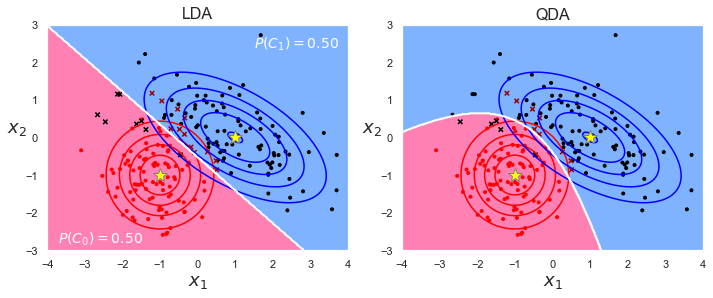

In [8]:
fig, ax = plt.subplots(1,2,figsize=(10,5), facecolor='white')


# Display PDF contours and centers    
color_set = ['red', 'blue', 'black']
for i in range(n_PDF):        
    rv = multivariate_normal(Mu[i,:], Sigma[:,:,i])
    for j in range(2):
        ax[j].contour(xx, yy, rv.pdf(pos), levels=5, colors=color_set[i])

        # Display PDF centers
        ax[j].plot(Mu[i][0], Mu[i][1],'*', color='yellow', markersize=15, markeredgecolor='grey')


# Remove datapoints outside figure limits
indx = np.argwhere((X[:,0]>x_min) & (X[:,0]<x_max) & (X[:,1]>y_min) & (X[:,1]<y_max)).ravel()
X = X[indx,:]
y = y[indx]    




# Method I: Linear Discriminant Analysis (LDA)
discriminant = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)  

plot_dataset(X,y, discriminant, xx, yy, ax[0])

# Text annotations
str0 = '$P(C_{0})=%.2f$' % (prob_C[0])
str1 = '$P(C_{1})=%.2f$' % (prob_C[1])
text = [str0, str1]  
text_pos = np.zeros((2,2))
text_pos[0,:] = [-3.7, -2.7]
text_pos[1,:] = [1.5, 2.5]
for i in range(n_PDF):
    ax[0].text(text_pos[i][0], text_pos[i][1], text[i], horizontalalignment='left', verticalalignment='center', fontsize=14, color='white')

    
ax[0].set_xlabel('$x_{1}$',fontsize=18)
ax[0].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
ax[0].xaxis.set_label_coords(0.5, -0.1)
ax[0].yaxis.set_label_coords(-0.1, 0.5)        
ax[0].set_title("LDA",fontsize=16)
ax[0].axis('scaled')


# Method II: Quadratic Discriminant Analysis (QDA)
discriminant = QuadraticDiscriminantAnalysis(store_covariance=True)

plot_dataset(X,y, discriminant, xx, yy, ax[1])

ax[1].set_xlabel('$x_{1}$',fontsize=18)
ax[1].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
ax[1].xaxis.set_label_coords(0.5, -0.1)
ax[1].yaxis.set_label_coords(-0.1, 0.5)        
ax[1].set_title("QDA",fontsize=16)
ax[1].axis('scaled')



fig.tight_layout()
plt.savefig("Classification_examples_with_LDA_and_QDA_methods_1.png", format="png")        
plt.show()

# Part II:   Various examples of gaussian mixtures with classification results. 
The following two functions contain most of the code in the previous cells; we use them to
display the classification results for each example.

In [9]:
def generate_LDA_and_QDA_classifications(Mu, sigma, theta, prob_C, npts, x_min, x_max, y_min, y_max, figName, text, text_pos):
        
    #---- Generate TRUE gaussian probability data distributions (PDF) ----------
    
    # Compute the covariance matrix Sigma for each gaussian PDF
    n_PDF = prob_C.shape[0]
    Sigma = np.zeros((2, 2, n_PDF))
    for n in range(n_PDF):
        cov = np.zeros((2, 2))

        # Rotation matrix
        angle = np.radians(theta[n])
        c, s = np.cos(angle), np.sin(angle)
        R = np.array([[c, -s], [s, c]])

        # Covariance matrix for a PDF with its principal axes oriented along the x and y directions
        C = np.array([[sigma[n,0]**2, 0.],[0., sigma[n,1]**2]])

        # Covariance matrix after rotation
        Sigma[:,:,n] = R.dot(C.dot(R.T))


    # Generate a spatial grid where the PDF will be evaluated locally.
    nx, ny = 300, 300
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    pos = np.dstack((xx, yy)) 
    

    # Compute the global PDF as a sum of weighted PDF
    pdf = 0
    for n in range(n_PDF):
        model = multivariate_normal(Mu[n,:], Sigma[:,:,n]) 
        pdf +=prob_C[n]*model.pdf(pos)

        
    #------ Generate datasets based on the TRUE PDF and estimate the PDF parameters from them --------
    
    # Number of data points allocated to each PDF 
    n = (npts*prob_C).astype(int)

    # Estimates of parameter values
    Mu_hat = np.zeros((n_PDF,2))
    Sigma_hat = np.zeros((2,2,n_PDF))
    
    # Generate a dataset from the PDF component #0
    X = np.random.multivariate_normal(Mu[0,:], Sigma[:,:,0], n[0])
    y = np.zeros(n[0])
    
    # Evaluate the gaussian PDF parameters for the dataset        
    Mu_hat[0,:] = np.mean(X,axis=0)
    Sigma_hat[:,:,0] = np.cov(X.T)         
    
    for i in range(1,n_PDF):
        # Generate a dataset from the PDF component #i
        Xi = np.random.multivariate_normal(Mu[i,:], Sigma[:,:,i], n[i])
        yi = i*np.ones(n[i])
        
        # Store the dataset
        X = np.r_[X, Xi]        
        y = np.hstack((y, yi))
                      
        # Evaluate the gaussian PDF parameters for the dataset   
        Mu_hat[i,:] = np.mean(Xi,axis=0)
        Sigma_hat[:,:,i] = np.cov(Xi.T)                      
    
    pC_hat = prob_C

    
    # --------- Classification using the LDA and the QDA methods ---------
    fig, ax = plt.subplots(1,2,figsize=(10,5), facecolor='white')
    
    
    # Display PDF contours and centers    
    color_set = ['red', 'blue', 'black']
    for i in range(n_PDF):        
        rv = multivariate_normal(Mu[i,:], Sigma[:,:,i])
        for j in range(2):
            ax[j].contour(xx, yy, rv.pdf(pos), levels=5, colors=color_set[i])

            # Display PDF centers
            ax[j].plot(Mu[i][0], Mu[i][1],'*', color='yellow', markersize=15, markeredgecolor='grey')


    # Remove datapoints outside figure limits
    indx = np.argwhere((X[:,0]>x_min) & (X[:,0]<x_max) & (X[:,1]>y_min) & (X[:,1]<y_max)).ravel()
    X = X[indx,:]
    y = y[indx]    
    
    
    
    
    # Method I: Linear Discriminant Analysis (LDA)
    discriminant = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)  
                      
    plot_dataset(X,y, discriminant, xx, yy, ax[0])
                      
    for i in range(n_PDF):
        ax[0].text(text_pos[i][0], text_pos[i][1], text[i], horizontalalignment='left', verticalalignment='center', fontsize=14, color='white')

    ax[0].set_xlabel('$x_{1}$',fontsize=18)
    ax[0].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
    ax[0].xaxis.set_label_coords(0.5, -0.1)
    ax[0].yaxis.set_label_coords(-0.1, 0.5)        
    ax[0].set_title("LDA",fontsize=16)
    ax[0].axis('scaled')

    
    # Method II: Quadratic Discriminant Analysis (QDA)
    discriminant = QuadraticDiscriminantAnalysis(store_covariance=True)
                      
    plot_dataset(X,y, discriminant, xx, yy, ax[1])
                      
    ax[1].set_xlabel('$x_{1}$',fontsize=18)
    ax[1].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
    ax[1].xaxis.set_label_coords(0.5, -0.1)
    ax[1].yaxis.set_label_coords(-0.1, 0.5)     
    ax[1].set_title("QDA",fontsize=16)
    ax[1].axis('scaled')

                      
                    
    fig.tight_layout()
    plt.savefig(figName, format="png")        
    plt.show()
    
    

In [10]:
def plot_dataset(X,y, discriminant, xx, yy, ax):

    # Predicted class on dataset
    y_pred = discriminant.fit(X, y).predict(X) 
    
    # True Positive
    tp = (y == y_pred)  
        
    # False Positive
    fp = (y != y_pred)  
        
    # Predicted classes on the grid     
    Xgrid = np.c_[xx.ravel(), yy.ravel()]
    C = discriminant.predict(Xgrid)  
    C = C.reshape(xx.shape)

    # Identify true and false positives for each class
    indx = np.where(tp)
    X_tp = np.squeeze( X[indx,:] )
    y_tp = y[indx]
    
    indx = np.where(fp)
    X_fp = np.squeeze( X[indx,:] )
    y_fp = y[indx]
    
     
    # Display classified data points (well classified '.', wrongly classified 'x')
    cmap1 = colors.ListedColormap(['red', 'blue', 'black'])
    cmap2 = colors.ListedColormap(['#990000', '#000099', '#000000'])
    ax.scatter(X_tp[:, 0], X_tp[:, 1], marker='.', cmap=cmap1, c=y_tp)
    ax.scatter(X_fp[:, 0], X_fp[:, 1], marker='x', s=20, cmap=cmap2, c=y_fp)

    
    # Display influence zone of each class
    n_PDF = y.max() + 1
    if (n_PDF==2):
        ax.pcolormesh(xx, yy, C, cmap='red_blue_classes', norm=colors.Normalize(0., 1.), zorder=0) 

        # Display the influence zone of each class
        ax.contour(xx, yy, C, [0.5], linewidths=2., colors='white') 
    else:
        ax.pcolormesh(xx, yy, C, cmap='red_blue_classes', norm=colors.Normalize(0., 2.), zorder=0) 

        # Display the influence zone of each class
        ax.contour(xx, yy, C, [0.5, 1.5], linewidths=2., colors='white')              


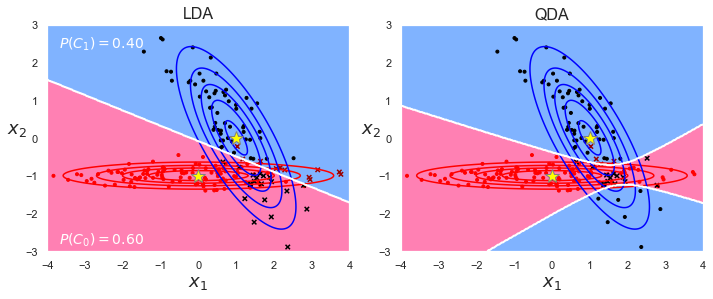

In [11]:
# For replicability
np.random.seed(42)
        
    
# Parameters of two gaussians PDF
Mu = np.zeros((2,2))
Mu[0,:] = [0., -1.]
Mu[1,:] = [1., 0.]

sigma = np.zeros((2,2))
sigma[0,:] = [2, .2]
sigma[1,:] = [1.5, .5]

theta = np.array([0., -60]) 
prob_C = np.array([0.6, 0.4]) 

npts = 200

x_min, x_max = -4., 4.
y_min, y_max = -3., 3.

# Annotations
str0 = '$P(C_{0})=%.2f$' % (prob_C[0])
str1 = '$P(C_{1})=%.2f$' % (prob_C[1])
text = [str0, str1]  

text_pos = np.zeros((2,2))
text_pos[0,:] = [-3.7, -2.7]
text_pos[1,:] = [-3.7, 2.5]


figName = "Classification_examples_with_LDA_and_QDA_methods_2.png"
generate_LDA_and_QDA_classifications(Mu, sigma, theta, prob_C, npts, x_min, x_max, y_min, y_max, figName, text, text_pos)
    

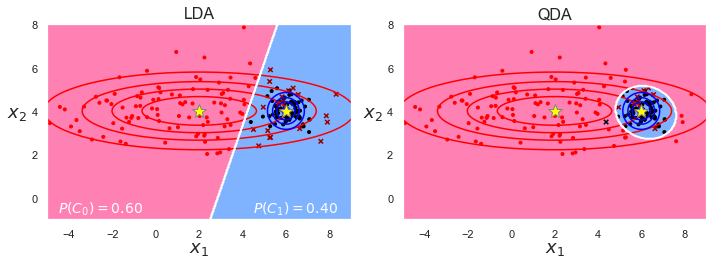

In [12]:
# For replicability
np.random.seed(42)
        
    
# Parameters of two gaussians PDF
Mu = np.zeros((2,2))
Mu[0,:] = [2., 4.]
Mu[1,:] = [6., 4.]

sigma = np.zeros((2,2))
sigma[0,:] = [4., 1.]
sigma[1,:] = [.5, .5]

theta = np.array([0., 0.]) 
prob_C = np.array([0.6, 0.4])  

npts = 200

x_min, x_max = -5., 9.
y_min, y_max = -1., 8.

# Annotations
str0 = '$P(C_{0})=%.2f$' % (prob_C[0])
str1 = '$P(C_{1})=%.2f$' % (prob_C[1])
text = [str0, str1]  

text_pos = np.zeros((2,2))
text_pos[0,:] = [-4.5, -0.5]
text_pos[1,:] = [4.5, -0.5]  


figName = "Classification_examples_with_LDA_and_QDA_methods_3.png"
generate_LDA_and_QDA_classifications(Mu, sigma, theta, prob_C, npts, x_min, x_max, y_min, y_max, figName, text, text_pos)
    

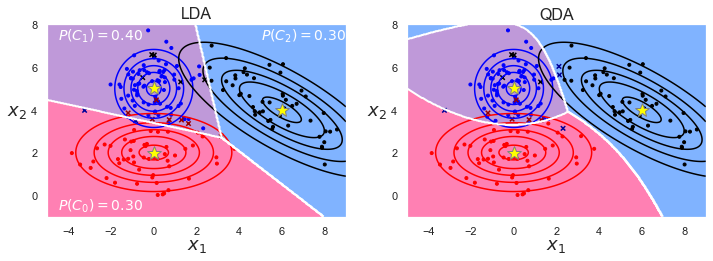

In [13]:
# For replicability
np.random.seed(42)
        
    
# Parameters of three gaussians PDF
Mu = np.zeros((3,2))
Mu[0,:] = [0., 2.]
Mu[1,:] = [0., 5.]
Mu[2,:] = [6., 4.]

sigma = np.zeros((3,2))
sigma[0,:] = [2., 1.]
sigma[1,:] = [1., 1.]
sigma[2,:] = [1., 3.]

theta = np.array([0., 0., 60]) 
prob_C = np.array([0.3, 0.4, 0.3]) 

npts = 200

x_min, x_max = -5., 9.
y_min, y_max = -1., 8.

# Annotations
str0 = '$P(C_{0})=%.2f$' % (prob_C[0])
str1 = '$P(C_{1})=%.2f$' % (prob_C[1])
str2 = '$P(C_{2})=%.2f$' % (prob_C[2])
text = [str0, str1, str2]

text_pos = np.zeros((3,2))
text_pos[0,:] = [-4.5, -.5]
text_pos[1,:] = [-4.5, 7.5]
text_pos[2,:] = [5., 7.5]    


figName = "Classification_examples_with_LDA_and_QDA_methods_4.png"
generate_LDA_and_QDA_classifications(Mu, sigma, theta, prob_C, npts, x_min, x_max, y_min, y_max, figName, text, text_pos)
    